In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc
import collections

import sys
sys.path.append('../prepare_gustav/src/')

from gustav import ebi, ncbi, nlm, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gtfparse import read_gtf

In [2]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, Circle, EdgesAndLinkedNodes, TapTool, NodesAndLinkedEdges, OpenURL, Title
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
import networkx as nx

In [15]:
!pip install --upgrade --user networkx

  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)


In [5]:
help(nx)

Help on package networkx:

NAME
    networkx

DESCRIPTION
    NetworkX
    
    NetworkX is a Python package for the creation, manipulation, and study of the
    structure, dynamics, and functions of complex networks.
    
    See https://networkx.org for complete documentation.

PACKAGE CONTENTS
    algorithms (package)
    classes (package)
    conftest
    convert
    convert_matrix
    drawing (package)
    exception
    generators (package)
    linalg (package)
    readwrite (package)
    relabel
    testing (package)
    tests (package)
    utils (package)

SUBMODULES
    adjacency
    adjlist
    algebraicconnectivity
    all
    approximation
    assortativity
    astar
    asteroidal
    atlas
    attracting
    attrmatrix
    beamsearch
    bethehessianmatrix
    betweenness
    betweenness_subset
    biconnected
    binary
    bipartite
    boundary
    breadth_first_search
    centrality
    chains
    chordal
    classic
    clique
    closeness
    cluster
    cographs
  

In [6]:
%%time
gene_info = ncbi.gene_info(taxon_ncbi=9606, mode='unambiguous_ensembl')

../prepare_gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_with_delimiter.drop(column, 1).reset_index(),


Wall time: 897 ms


../prepare_gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  joined = joined.drop('helper_index', 1)


In [7]:
%%time
gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=9606)

Wall time: 114 ms


In [8]:
%%time

ml = ncbi.pubmed(
    'main',
    ['pubmed_id', 'pubdate']   # there are many more columns, including abstracts
).rename(
    columns={'pubdate': 'year'}
).groupby('pubmed_id')['year'].min().reset_index()

Wall time: 10.1 s


In [9]:
%%time
gene2pubmed = pd.merge(gene2pubmed, ml, on='pubmed_id', how='left')

Wall time: 9.44 s


In [10]:
gene2pubmed_new = gene2pubmed.copy()

In [11]:
gene2pubmed_new = gene2pubmed_new[(gene2pubmed_new['year'] >= 2000) & (gene2pubmed_new['year'] <= 2018)]

<AxesSubplot:xlabel='pubmed_id'>

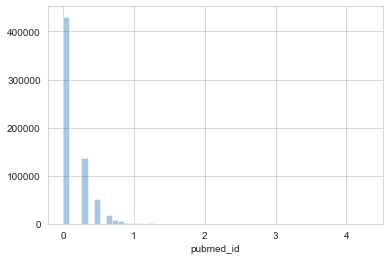

In [12]:
sns.distplot(np.log10(gene2pubmed['pubmed_id'].value_counts()), kde=False)

### Top 100 most popular genes

In [13]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index[0:100].values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 0.3*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 1.76 s


In [14]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'w_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = "Gene literature network (100 most popular genes, 2000-2018)"

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.2, 10.2), y_range=Range1d(-10.2, 10.2), title=title, plot_width=1000, plot_height=650)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=linear_cmap(color_by_this_attribute, 
                                                                  color_palette, 
                                                                  minimum_value_color, 
                                                                  maximum_value_color))
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.01*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
save(plot, filename=f"gene_literature_network_top100.html")

C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:127: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:140: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'C:\\Users\\Ibis Grad\\Documents\\GitHub\\gene_literature_network\\gene_literature_network_top100.html'

### Top 200 most popular genes

In [109]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index[0:200].values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 0.3*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 5.47 s


In [110]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'w_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = "Gene literature network (200 most popular genes, 2000-2018)"

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.2, 10.2), y_range=Range1d(-10.2, 10.2), title=title, plot_width=1000, plot_height=650)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=linear_cmap(color_by_this_attribute, 
                                                                  color_palette, 
                                                                  minimum_value_color, 
                                                                  maximum_value_color))
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.01*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
save(plot, filename=f"gene_literature_network_top200.html")

'C:\\Users\\Ibis Grad\\Documents\\GitHub\\gene_literature_network\\gene_literature_network_top200.html'

### COSMIC genes

In [111]:
cosmic = pd.read_csv('./cosmic/Census_allWed Mar 30 01_24_29 2022.csv').fillna('')

In [112]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.index.isin(gene_info['gene_ncbi'])) & (gene_count.index.isin(cosmic['Entrez GeneId']))].index.values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 0.3*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# role in cancer
cancer_role = dict([(node, cosmic.loc[cosmic['Entrez GeneId'] == node]['Role in Cancer'].values[0].replace('TSG', 'tumor suppressor gene')) for node in list(G)])
nx.set_node_attributes(G, name='cancer_role', values=cancer_role)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 38.1 s


In [113]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'w_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = 'Gene literature network (only genes in COSMIC Cancer Gene Census, 714 genes)'

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"), 
    ("Role in cancer", "@cancer_role"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, plot_width=1000, plot_height=600)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=linear_cmap(color_by_this_attribute, 
                                                                  color_palette, 
                                                                  minimum_value_color, 
                                                                  maximum_value_color))
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.01*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
save(plot, filename=f"gene_literature_network_cosmic.html")

'C:\\Users\\Ibis Grad\\Documents\\GitHub\\gene_literature_network\\gene_literature_network_cosmic.html'

# proteostasis network

In [15]:
pn_df = pd.read_csv('./proteostasis/pn_network_211212.csv')

name_to_entrez_dict = dict(zip(gene_info['symbol_ncbi'], gene_info['gene_ncbi']))

# get entrez for genes with only name
pn_df['gene_ncbi'] = pn_df['symbol_ncbi'].apply(lambda x: name_to_entrez_dict.get(x))

# drop those still without entrez
pn_df = pn_df.dropna(subset=['gene_ncbi'])

# insert Falses
pn_df[['cytosol','endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']] = pn_df.loc[:, ['cytosol',
       'endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']].fillna(False)

# remove ambiguous
pn_df = pn_df[~pn_df['ambiguous']]

# remove duplicates
pn_df = pn_df.groupby('gene_entrez').max().reset_index()

In [16]:
# neat str describing pn_role
pn_df['pn_role'] = ''

for index, row in pn_df.iterrows():
    
    pn_role = ''
    if row['canon_chaperones']:
        pn_role = pn_role + 'canon chaperone, '
    if row['cytosol']:
        pn_role = pn_role + 'cytosolic, '
    if row['endoplasmic_reticulum']:
        pn_role = pn_role + 'ER, '
    if row['mitochondrial']:
        pn_role = pn_role + 'ER, '
    if row['ubq']:
        pn_role = pn_role + 'ubiquitin system, '
    if row['autophagy']:
        pn_role = pn_role + 'autophagy, '
    if row['ribosomal_qc']:
        pn_role = pn_role + 'ribosome QC, '
        
    if np.sum(row[['cytosol','endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones']]) > 0:
        pn_role = pn_role[:-2]
        
    pn_df.loc[index, 'pn_role'] = pn_role

In [17]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.index.isin(gene_info['gene_ncbi'])) & 
                               (gene_count.index.isin(pn_df['gene_ncbi']))].index.values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 1*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# role in proteostasis
pn_role = dict([(node, pn_df.loc[pn_df['gene_ncbi'] == node]['pn_role'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='pn_role', values=pn_role)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 3.03 s


In [18]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'w_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = 'Gene literature network (proteostasis network, 429 genes)'

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"), 
    ("role", "@pn_role"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, plot_width=1000, plot_height=600)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=linear_cmap(color_by_this_attribute, 
                                                                  color_palette, 
                                                                  minimum_value_color, 
                                                                  maximum_value_color))
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.1*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
save(plot, filename=f"gene_literature_network_proteostasis.html")

'C:\\Users\\Ibis Grad\\Documents\\GitHub\\gene_literature_network\\gene_literature_network_proteostasis.html'

In [19]:
def get_partner_str(node, n_partners = 3):
    '''
        returns top-weighted node partners. node is a int index.
    '''
    partners_str = ''
    weights = np.array([edge[2].get('weight') for edge in list(G.edges(node, data=True))])
    partners = np.array([edge[1] for edge in list(G.edges(node, data=True))])
    top3_weights = weights[(-weights).argsort()][0:n_partners]
    top3_partners = partners[(-weights).argsort()][0:n_partners]
    for weight, partner in zip(top3_weights, top3_partners):
        partner_symbol = gene_info.loc[gene_info['gene_ncbi'] == partner]['symbol_ncbi'].values[0]
        partners_str = partners_str + partner_symbol + ' (' + str(weight) + ' pubs), '
    partners_str = partners_str[:-2]
    return partners_str

In [20]:
get_partner_str(3301, n_partners=3)

'HSPA8 (10 pubs), HSP90AA1 (5 pubs), DNAJB1 (5 pubs)'

In [21]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.index.isin(gene_info['gene_ncbi'])) & 
                               (gene_count.index.isin(pn_df['gene_ncbi']))].index.values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 1*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# role in proteostasis
pn_role = dict([(node, pn_df.loc[pn_df['gene_ncbi'] == node]['pn_role'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='pn_role', values=pn_role)

# partner list
partner_strs = dict([(node, get_partner_str(node, n_partners=3)) for node in list(G)])
nx.set_node_attributes(G, name='top_partners', values=partner_strs)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 3.77 s


In [22]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'w_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = 'Gene literature network (proteostasis network, 429 genes)'

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"), 
    ("role", "@pn_role"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree"), 
    ("top partners", "@top_partners")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, plot_width=1000, plot_height=600)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=linear_cmap(color_by_this_attribute, 
                                                                  color_palette, 
                                                                  minimum_value_color, 
                                                                  maximum_value_color))
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.1*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
save(plot, filename=f"gene_literature_network_proteostasis.html")

'C:\\Users\\Ibis Grad\\Documents\\GitHub\\gene_literature_network\\gene_literature_network_proteostasis.html'

In [58]:
communities = nx.community.greedy_modularity_communities(G, weight='weight')

# Create empty dictionaries
modularity_class = {}
modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    if community_number < 8:
        for name in community: 
            modularity_class[name] = community_number
            modularity_color[name] = Spectral8[community_number]
    else:
        for name in community: 
            modularity_class[name] = community_number
            modularity_color[name] = 'gray'

In [59]:
nx.set_node_attributes(G, modularity_class, 'modularity_class')
nx.set_node_attributes(G, modularity_color, 'modularity_color')
nx.set_node_attributes(G, 1, 'default_color')

In [60]:
# seed for node positions
spring_seed=0

# size and color attributes
size_by_this_attribute = 'size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Choose colors for node and edge highlighting
node_highlight_color = 'red'
edge_highlight_color = 'red'

title = 'Gene literature network (proteostasis network, 429 genes)'

#Establish which categories will appear when hovering over each node
hover_tooltips = [
    ("EntrezID", "@index"),
    ("gene symbol", "@symbol"),
    ("gene name", "@description"),
    ("NCBI (click node to open)", "@NCBI"), 
    ("role", "@pn_role"),
    ("# pubs (2000-2018)", "@n_pubs"),
    ("# co-mentioned genes (in this net)", "@u_degree"),
    ("# co-mentions (in this net)", "@w_degree"), 
    ("top partners", "@top_partners")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = hover_tooltips,
              tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, plot_width=1000, plot_height=600)

# add subtitles
plot.add_layout(Title(text="Node size corresponds to # publications from 2000 to 2018, edge width corresponds to # co-mentions of two genes", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Node color corresponds to # mentions alongside other genes in publications from 2000 to 2018", text_font_style="italic"), 'above')
plot.add_layout(Title(text="Hover for gene info, click to open NCBI page", text_font_style="italic"), 'below')

#Create a network graph object
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0), k=2, seed=spring_seed)

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, 
                                           fill_color=color_by_this_attribute)
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, 
                                                 line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, 
                                                     line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.data_source.data["line_width"] = [0.1*G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
network_graph.edge_renderer.data_source.data["line_alpha"] = [0.75 for edge in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.edge_renderer.glyph.line_alpha = {'field': 'line_alpha'}
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)
network_graph.edge_renderer.nonselection_glyph = MultiLine(line_alpha=0)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='line_width', line_alpha=1)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

url = "https://ncbi.nlm.nih.gov/gene/@index"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible = False

show(plot)
#save(plot, filename=f"gene_literature_network_proteostasis.html")

In [432]:
!pip freeze > requirements_long.txt

In [431]:
!jupyter nbconvert --output-dir="." --to script gene_literature_network.ipynb
!pipreqs --force

[NbConvertApp] Converting notebook gene_literature_network.ipynb to script
[NbConvertApp] Writing 21088 bytes to .\gene_literature_network.py
INFO: Successfully saved requirements file in C:\Users\Ibis Grad\Documents\GitHub\gene_literature_network\requirements.txt
